<IPython.core.display.Javascript object>


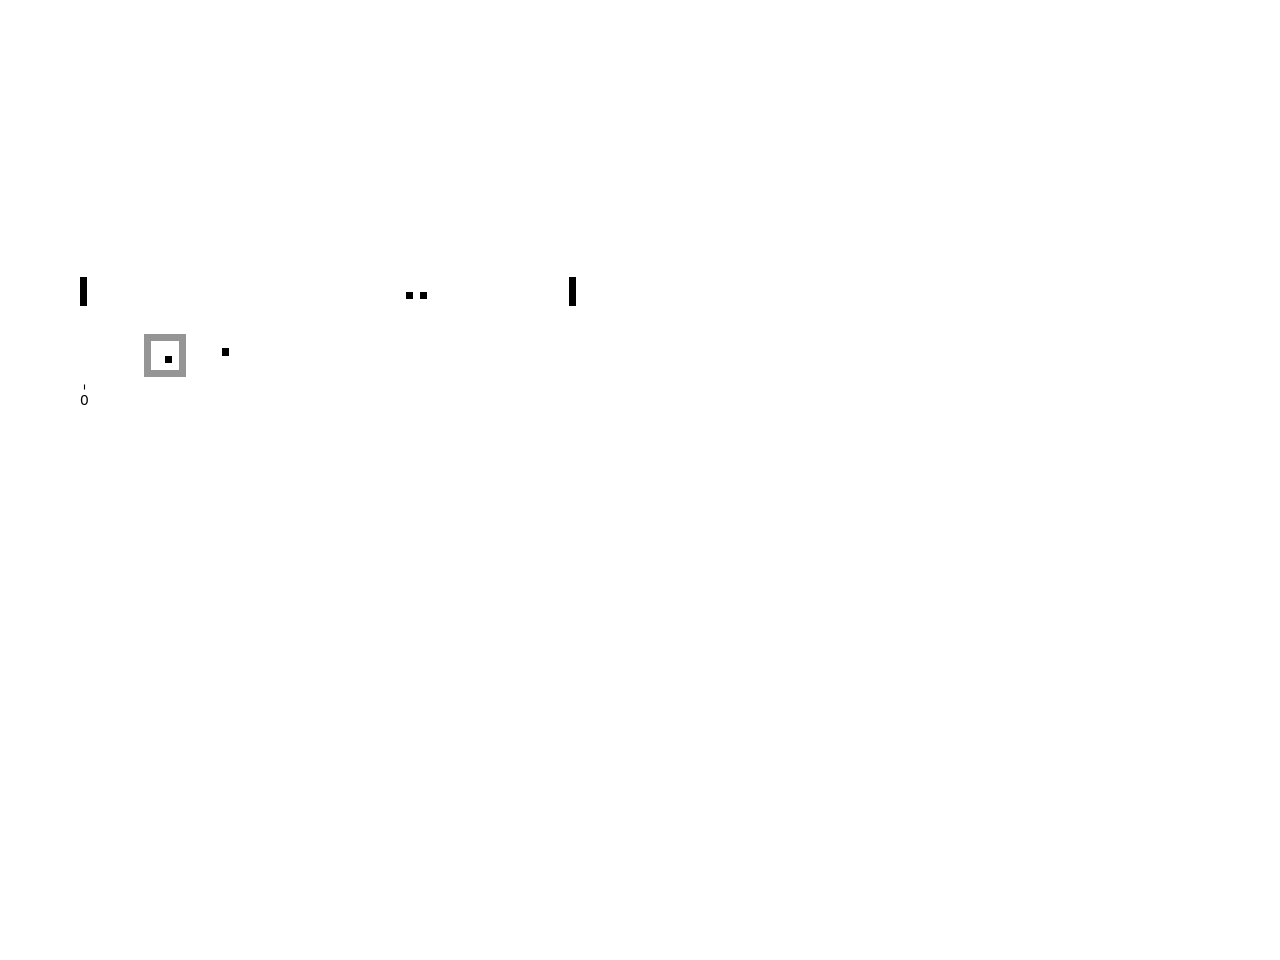

KeyboardInterrupt: 

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

import numpy as np

#params
height = 40
width = 70
rounds = 2000
bar = 2
bals = 4
speed = 1

np.random.seed(0)

def init(bals):
    pos = []
    for j in range(bals):
        x_start = np.random.randint(round(height*0.25), round(height*0.75))
        y_start = np.random.randint(round(width*0.25), round(width*0.75))
        position = np.array([x_start, y_start])
        speed = np.array([1 if np.random.randint(2) == 1 else -1, 
                 1 if np.random.randint(2) == 1 else -1])
        pos.append([position, speed])

    player1 = np.random.randint(height)
    player2 = np.random.randint(height)
    
    return pos, player1, player2

def update_ball(position, speed):
    if position[0] == 0:
        speed[0] = 1
    if position[0] == height - 1:
        speed[0] = -1
    if position[1] == 0:
        speed[1] = 1
    if position[1] == width - 1:
        speed[1] = -1
    position+=speed
    return [position, speed]
    
def update_player1(pos, player1, player2):
    return generic_player(pos, player1, 0)

def update_player2(pos, player1, player2):
    return generic_player(pos, player2, width -1)
    
def get_matrix(g, pos, player1, player2, attention1, attention2):
    g = g*0

    att1 = pos[attention1][0]
    att2 = pos[attention2][0]
    
    g[att1[0] - 3: att1[0] + 3, att1[1] - 3: att1[1] + 3] = 1
    g[att1[0] - 2: att1[0] + 2, att1[1] - 2: att1[1] + 2] = 0
    
    for v in pos:
        g[v[0][0], v[0][1]] = 2
    g[player1 - bar: player1 + bar, 0] = 2
    g[player2 - bar: player2 + bar, width -1] = 2
    
    return g
    
def generic_player(pos, player, player_pos):
    # First we check which ball we should pay attention to
    dist = np.Inf
    counter = 0
    for v in pos:
        if np.abs(player_pos - v[0][1]) < dist:
            position = v[0]
            dist = np.abs(player_pos - v[0][1])
            attention = counter
        counter +=1
    if position[0] > player:
        player+=1
    elif position[0] < player:
        player-=1 
    if player < bar:
        return bar, attention
    if player > height - bar - 1:
        return height - bar - 1, attention
    return player, attention
    
def check_game(pos, speed, player1, player2):
    # Check player 1
    for v in pos:
        position = v[0]
        if position[1] == 0:
            if position[0] > player1 + bar or position[0] < player1 - bar:
                points[1] += 1
                return init(bals)
    
    # Check player 2:
    for v in pos:
        position = v[0]
        if position[1] == width - 1:
            if position[0] > player2 + bar or position[0] < player2 - bar:
                points[0] += 1
                return init(bals)

    return pos, player1, player2

# Play the game
pos, player1, player2 = init(bals)
g = np.zeros((height, width))
fig,ax = plt.subplots(1,1)
points = np.zeros(2)

for i in range(rounds):
    pos, player1, player2 = check_game(pos, speed, player1, player2)
    for v in pos:
        v = update_ball(v[0], v[1])
    player1, attention1 = update_player1(pos, player1, player2)
    player2, attention2 = update_player2(pos, player1, player2)
    
    g = get_matrix(g, pos, player1, player2, attention1, attention2)
    ax.clear()
    ax.imshow(g, cmap='Greys') 
    #ax.imshow(g)
    ax.set_title("Score: {} {}".format(int(points[0]), int(points[1])))
    fig.canvas.draw()
    #time.sleep(.001)

In [ ]:
def get_rect(x, y, width, height):
    rect = np.array([(0, 0), (width, 0), (width, height), (0, height), (0, 0)])
    offset = np.array([x, y])
    return rect + offset

get_rect(10,10, 100, 100)